In [4]:
%matplotlib inline
from ast import literal_eval

import io 
import os

import copy 

import tqdm

import pandas as pd
import numpy as np
import json

from scipy.spatial.distance import squareform
from scipy.stats import trim_mean 
from scipy.stats.mstats import trimmed_std

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from itertools import combinations,product,combinations_with_replacement

In [5]:
def custom_parser(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    # Determine the maximum number of columns
    max_columns = max(len(line.strip().split(',')) for line in lines)
    adjusted_lines = []
    
    for line in lines:
        columns = line.strip().split(',')
        # Add empty strings to match the max number of columns
        columns += [''] * (max_columns - len(columns))
        adjusted_lines.append(','.join(columns))
    
    # Join adjusted lines and read into DataFrame
    adjusted_content = '\n'.join(adjusted_lines)
    df = pd.read_csv(io.StringIO(adjusted_content), header=None, index_col=0)
    
    # Convert all columns to nullable integer type
    df = df.apply(pd.to_numeric, errors='coerce').convert_dtypes()
    
    return df

def rmse(y_pred, y_target):
    return np.sqrt(np.mean((y_pred-y_target)**2))

def mabse(y_pred, y_target):
    return np.mean(np.abs(y_pred-y_target))

def regret_fun(y_selected, y_opt):
    return np.sum(y_selected-y_opt)

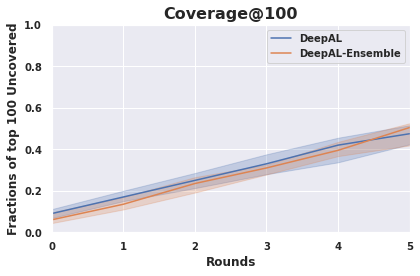

In [8]:
num_k = 100
n_genes = 50
n_pairs = int((n_genes * (n_genes - 1)) / 2)

n_samples_choice=[100]
n_rounds_choice=[5]

methods=["max-optimism"]
experiment_names=["DeepAL-Sample-Run", "DeepAL-8GPUS-Sample-Run"]
# experiment_names=["DeepAL-Sample-Run", "DeepAL-8GPUS-Sample-Run", "DeepAL-8GPUS-Sample-Run-fixedembedding", "DeepAL-8GPUS-Sample-Run-noinitialtraining", "DeepAL-8GPUS-Sample-Run-freeembedding"]
# experiment_names=["bilinear-final-mp", "bilinear-final-noinitialtraining-mp", "bilinear-final-FE-mp", "bilinear-final-fixedembeddings-mp"]
colors_all = [f'C{i}' for i in range(len(experiment_names))]
label_dict = {"DeepAL-8GPUS-Sample-Run": "DeepAL-Ensemble", "DeepAL-Sample-Run": "DeepAL", "DeepAL-8GPUS-Sample-Run-noinitialtraining": "DeepAL-Ensemble-RandomInit", "DeepAL-8GPUS-Sample-Run-freeembedding": "UF-Ensemble", "DeepAL-8GPUS-Sample-Run-fixedembedding": "FF-Ensemble"}

num_replicate = 10

for n_samples,num_steps in zip(n_samples_choice, n_rounds_choice):
    for mtd_index, method in enumerate(methods):
        all_matches = np.empty((num_replicate,len(experiment_names),num_steps+1),dtype=float) # create an empty initaliziation
        for replicate in range(num_replicate):
            interaction_vector = np.load(f"../data/interaction_vector_r{replicate}.npy")
            top_k = np.argsort(interaction_vector)[:num_k]
            true_top = set(top_k)
            for exp_idx, experiment in enumerate(experiment_names):
                indices = np.arange(n_pairs)
                seen_mask = np.zeros(n_pairs, dtype=bool)
                if experiment != "DeepAL-Sample-Run":        
                    outfile = f"../outputs/{experiment}_batchsize_{n_samples}_numrounds_{num_steps}_r{replicate}.csv"
                else:
                    outfile = f"../outputs/Sample-Run_batchsize_{n_samples}_numrounds_{num_steps}_r{replicate}.csv"
                df= custom_parser(outfile)
                s=set()
                for k,ix in enumerate(df.values):
                    ix_array = np.array([element for element in ix if element is not pd.NA], dtype=np.int64)

                    if k>num_steps:
                        break
                    else:
                        s.update(ix_array)
                        all_matches[replicate,exp_idx,k]=len(s.intersection(true_top))
        all_matches = all_matches/num_k
        matches_median = np.quantile(all_matches, q=0.5, axis=0) 
        matches_5quantile = np.quantile(all_matches, q=0.159,axis=0)
        matches_95quantile = np.quantile(all_matches, q=0.841, axis=0)
        labels = [label_dict[name] for name in experiment_names]
        colors = colors_all
        rounds = np.arange(matches_median.shape[1])
        for i, (median, quantile_5, quantile_95, label, color) in enumerate(zip(matches_median, matches_5quantile, matches_95quantile, np.array(labels), colors)):
            plt.plot(median, '%s-' % color, label=label)
            plt.fill_between(rounds, quantile_5, quantile_95, alpha=0.25, color=color)
        plt.ylim(0, 1)
        #plt.xlim(-1, 25)
        plt.xlim(0, num_steps)
        plt.xlabel('Rounds',fontsize=12, weight='bold')
        plt.ylabel(f'Fractions of top {num_k} Uncovered',fontsize=12, weight='bold')
        plt.xticks(fontsize=10, weight='bold')
        plt.yticks(fontsize=10, weight='bold')
        plt.title(f'Coverage@{num_k}',fontsize=16, weight='bold')
        plt.legend(prop={'size': 10, 'weight': 'bold'})
        plt.tight_layout()
        # plt.savefig(f"Coverage@400_ablations_batchsize={n_samples}_rev.pdf")
        plt.show()
        plt.close()